### Country Leave One Out

Here we are doing a `leave-one-out` analysis on country. I have copied much from elsewhere, as I anticipate expanding this to other fields once I have it working, and so we ca use the same data frames, etc.

In [1]:
# some of these are not needed!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np


import math
import re

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_transposons
from PhiSpyAnalysis import read_logo

from scipy.stats import pearsonr, f_oneway, mode
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import decomposition, metrics
from sklearn.ensemble import RandomForestClassifier


import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA

from PhiSpyAnalysis import theils_u, DateConverter


import subprocess
import gzip


In [2]:
phagesdf=read_phages()

Please note that this was run with git commit 1a2a28b that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages, but after filtering we kept 1,961,109 prophages from 388,797 genomes

In [3]:
metadf = read_metadata()

## Read some categories

In [4]:
catdf = read_categories()

In [5]:
acccol = 'assembly_accession'
interesting_cols = [acccol, 'isolation_country', 'isolation_date']

tempdf = metadf[interesting_cols]
# tempdf = metadf[few_interesting_cols]
temp1 = pd.merge(tempdf, catdf, how='left', left_on=acccol, right_on=acccol)
# phagemeta = pd.merge(tempdf, phagesdf, how='inner', left_on=acccol, right_on=acccol)
# phagemeta.to_csv(os.path.join('results', 'example_isolations.tsv'), sep='\t')

phagemeta = pd.merge(temp1, phagesdf, how='right', left_on=acccol, right_on=acccol)
phagemeta

,assembly_accession,isolation_country,isolation_date,Category,Biome,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000043285.1,NaN,NaN,NaN,NaN,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0
1,GCA_000046685.1,France,1993.323066,human blood,Host-Associated,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0
2,GCA_000046705.1,United States,NaN,human blood,Host-Associated,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0
3,GCA_000046845.1,NaN,1957.958248,soil,Terrestrial,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0
4,GCA_000047365.1,NaN,NaN,human other,Host-Associated,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388792,GCA_905187425.1,NaN,NaN,NaN,NaN,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0
388793,GCA_905188235.1,NaN,NaN,NaN,NaN,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0
388794,GCA_905219375.1,NaN,2015.915811,NaN,NaN,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0
388795,GCA_905219385.1,NaN,2015.154689,NaN,NaN,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0


## Encode the data

In [6]:
# for the country LOO we only need one field and that should make the RF quicker!

pmenc = pd.DataFrame()
for c in ['isolation_country', 'Category']:
    pmenc[c] = phagemeta[c].astype('category').cat.codes
pmenc['isolation_date'] = phagemeta['isolation_date'].fillna(-1)
pmenc

,isolation_country,Category,isolation_date
0,-1,-1,-1.000000
1,63,14,1993.323066
2,209,14,-1.000000
3,-1,46,1957.958248
4,-1,22,-1.000000
...,...,...,...
388792,-1,-1,-1.000000
388793,-1,-1,-1.000000
388794,-1,-1,2015.915811
388795,-1,-1,2015.154689


In [7]:
x_train, x_test, y_train, y_test = train_test_split(pmenc['isolation_country'], phagemeta.Kept.values.ravel())
clf = RandomForestClassifier(random_state=42, n_estimators=10, bootstrap=True, n_jobs=-1, oob_score=True)
clf.fit(x_train.ravel().reshape(-1, 1), y_train)
y_pred = clf.predict(x_test.ravel().reshape(-1, 1))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
f1base = metrics.f1_score(y_test, y_pred, average='weighted')
print(f"f1\t{f1base}")

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


Accuracy: 0.1451440329218107
f1	0.0716780379933926


# LOGO Analysis

**NOTE**: This is run on the clusters, because it will take a while on your PC (like a day). So skip this step and read the results (see below)

I ran the code `LOGO.slurm` on the cluster, which really just runs `CountryLOGO.py`.

In [8]:
if False:
    logo = LeaveOneGroupOut()
    print("Leaving Out\tf1 delta")

    for trainidx, testidx in logo.split(x_train, y_train, groups=x_train):
        clf.fit(x_train.iloc[trainidx].ravel().reshape(-1, 1), y_train[trainidx])
        new_pred = clf.predict(x_test.ravel().reshape(-1, 1))
        f1measure = metrics.f1_score(y_test, new_pred, average='weighted')
        print(f"{pd.unique(x_train.iloc[testidx].values)}\t{f1base - f1measure}")


Read the already processed data!

In [9]:
logo = read_logo()

Groupby functions

- count() – Number of non-null observations
- sum() – Sum of values
- mean() – Mean of values
- median() – Arithmetic median of values
- min() – Minimum
- max() – Maximum
- mode() – Mode
- std() – Standard deviation
- var() – Variance

<div style="background-color: coral">
<h1>ERROR:</h1>
There is probably a problem below because we delete the NaN country column but include it in the sum, mean, median, etc
</div>

In [10]:
ic = pd.DataFrame(pd.unique(phagemeta['isolation_country'])).set_index(0)


ic['mean_phages'] = phagemeta.groupby('isolation_country').mean()['Kept']
ic['median_phages'] = phagemeta.groupby('isolation_country').median()['Kept']
ic['sum_phages'] = phagemeta.groupby('isolation_country').sum()['Kept']
ic['std_phages'] = phagemeta.groupby('isolation_country').std()['Kept']
ic['count_phages'] = phagemeta.groupby('isolation_country').count()['Kept']

ic['min_phages'] = phagemeta.groupby('isolation_country').agg(['min'])['Kept']
ic['max_phages'] = phagemeta.groupby('isolation_country').agg(['max'])['Kept']

ic['mode_phages'] = phagemeta.groupby('isolation_country').agg(lambda x: mode(x)[0])['Kept']
ic['var_phages'] = phagemeta.groupby('isolation_country').var()['Kept']

ic = ic.reset_index().rename({0:'Country'}, axis=1)
ic = ic[ic['Country'].notnull()]


ic

,Country,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
1,France,4.334419,4.0,3992.0,3.654211,921.0,0.0,30.0,4.0,13.353260
2,United States,3.570414,3.0,83462.0,3.131828,23376.0,0.0,29.0,0.0,9.808346
3,French Guiana,3.666667,3.0,22.0,1.966384,6.0,2.0,6.0,2.0,3.866667
4,Peru,2.681818,2.0,413.0,3.322934,154.0,0.0,24.0,1.0,11.041889
5,Italy,3.246606,3.0,4305.0,2.390920,1326.0,0.0,34.0,3.0,5.716498
...,...,...,...,...,...,...,...,...,...,...
214,Jersey,4.000000,4.0,8.0,1.414214,2.0,3.0,5.0,3.0,2.000000
215,C�te,0.000000,0.0,0.0,0.000000,2.0,0.0,0.0,0.0,0.000000
216,England,6.044444,5.0,272.0,2.055542,45.0,2.0,9.0,8.0,4.225253
217,Montenegro,7.416667,9.0,89.0,3.449857,12.0,1.0,12.0,9.0,11.901515


In [11]:
iclogo = pd.merge(logo, ic, on='Country', how='inner')
iclogo

,Code,Country,f1 delta,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
0,0,Adriatic Sea,0.000040,2.500000,2.5,5.0,0.707107,2.0,2.0,3.0,2.0,0.500000
1,1,Afghanistan,-0.000049,4.166667,4.0,25.0,1.602082,6.0,2.0,6.0,4.0,2.566667
2,10,Arctic Ocean,0.000100,1.750000,2.0,56.0,1.759765,32.0,0.0,7.0,0.0,3.096774
3,100,Jordan,0.000120,3.600000,2.5,36.0,2.875181,10.0,1.0,11.0,2.0,8.266667
4,101,Kazakhstan,0.000113,4.722222,5.0,85.0,2.865732,18.0,1.0,11.0,5.0,8.212418
...,...,...,...,...,...,...,...,...,...,...,...,...
209,95,Ireland,0.000095,4.139665,4.0,741.0,2.636720,179.0,0.0,14.0,3.0,6.952294
210,96,Israel,0.000535,3.574233,3.0,2913.0,2.107451,815.0,0.0,17.0,3.0,4.441350
211,97,Italy,-0.000244,3.246606,3.0,4305.0,2.390920,1326.0,0.0,34.0,3.0,5.716498
212,98,Jamaica,-0.000047,3.666667,4.0,11.0,1.527525,3.0,2.0,5.0,2.0,2.333333


c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


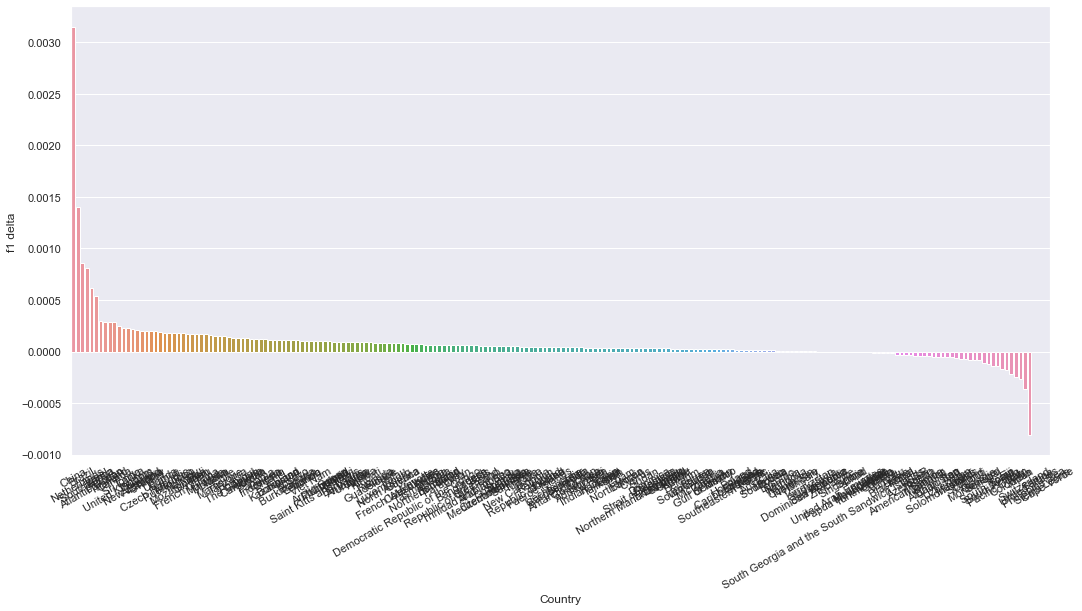

In [12]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
ax = sns.barplot(x='Country', y='f1 delta', data=iclogo.sort_values(by='f1 delta', ascending=False))
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

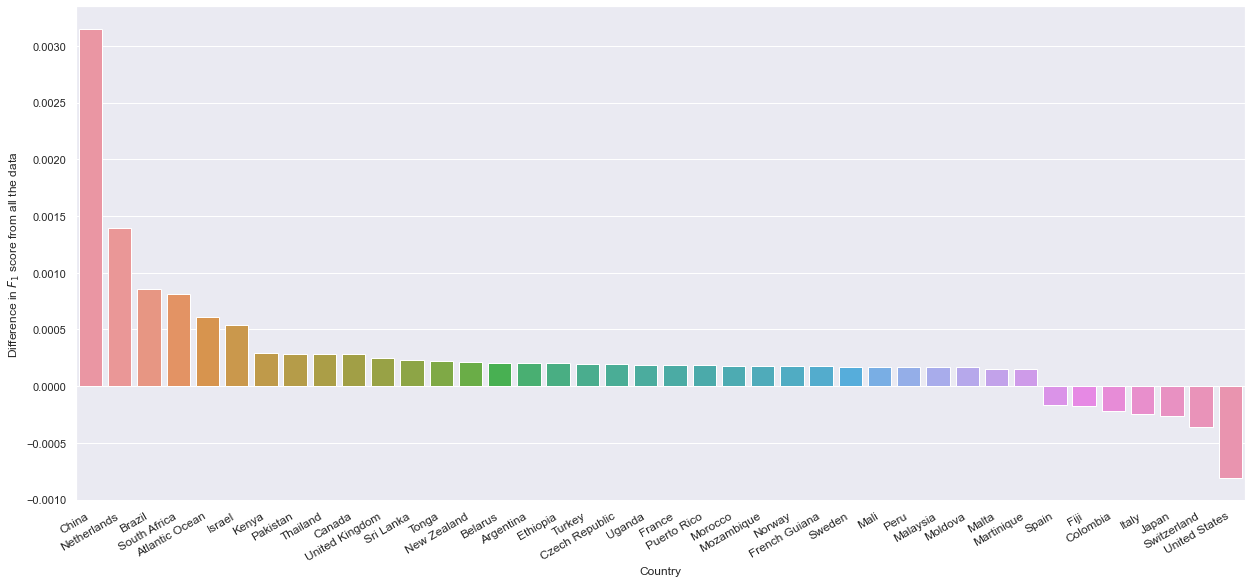

In [13]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
iclogotop = iclogo[iclogo['f1 delta'].abs() > 0.00015].sort_values(by='f1 delta', ascending=False)
ax = sns.barplot(x='Country', y='f1 delta', data=iclogotop)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=12)
ax.set_ylabel("Difference in $F_1$ score from all the data")
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/country_importance.png')
fig.savefig('images/country_importance.svg')

In [14]:
iclogotop

,Code,Country,f1 delta,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
155,41,China,0.003151,4.297557,4.0,23224.0,2.874883,5404.0,0.0,32.0,4.0,8.264951
41,137,Netherlands,0.001397,2.445882,2.0,2079.0,2.388136,850.0,0.0,22.0,1.0,5.703193
144,31,Brazil,0.000860,4.064309,4.0,5056.0,2.655139,1244.0,0.0,21.0,3.0,7.049763
93,186,South Africa,0.000809,3.179756,2.0,7288.0,2.297204,2292.0,0.0,18.0,2.0,5.277146
34,13,Atlantic Ocean,0.000612,0.870492,0.0,531.0,1.293389,610.0,0.0,7.0,0.0,1.672855
210,96,Israel,0.000535,3.574233,3.0,2913.0,2.107451,815.0,0.0,17.0,3.0,4.441350
5,102,Kenya,0.000295,3.526667,3.0,1587.0,2.252531,450.0,0.0,21.0,2.0,5.073898
56,151,Pakistan,0.000284,5.111111,5.0,1564.0,2.377643,306.0,0.0,14.0,4.0,5.653188
115,207,Thailand,0.000283,5.018094,5.0,4160.0,2.580288,829.0,0.0,29.0,4.0,6.657885
149,36,Canada,0.000283,3.806159,3.0,7540.0,3.079384,1981.0,0.0,25.0,3.0,9.482609


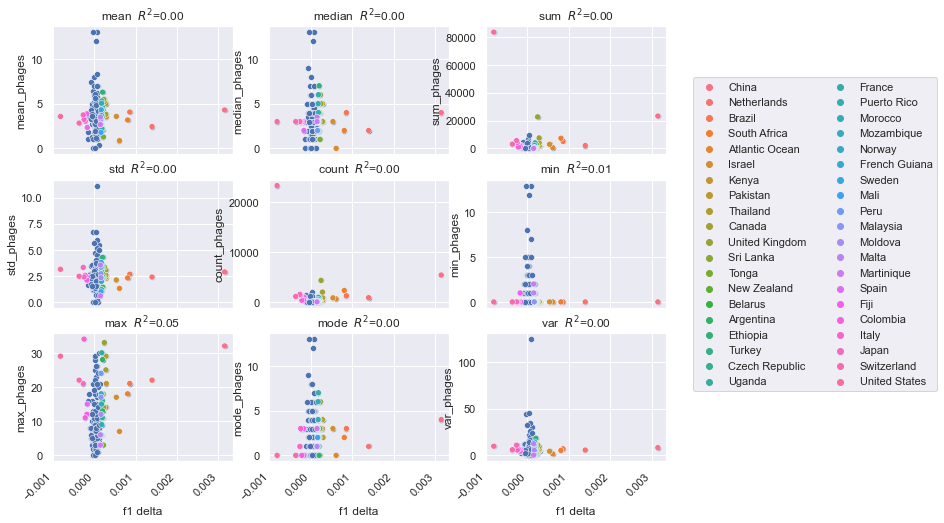

In [15]:
cols = [
        ['mean_phages', 'median_phages', 'sum_phages'],
        ['std_phages', 'count_phages', 'min_phages'], 
        ['max_phages', 'mode_phages', 'var_phages']
]

model = LinearRegression()

datalen = len(iclogo['f1 delta'])
x = iclogo['f1 delta'].fillna(0).values.reshape(datalen, 1)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(11, 8), sharex=True)

for i in 0,1,2:
    for j in 0,1,2:
        y = iclogo[cols[i][j]].fillna(0).values.reshape(datalen, 1)
        m = model.fit(x, y)        
        bx = sns.scatterplot(x='f1 delta', y=cols[i][j], data=iclogo, ax=ax[i][j])
        bx2 =  sns.scatterplot(x='f1 delta', y=cols[i][j], data=iclogotop, ax=ax[i][j], hue='Country')
        bx2.get_legend().remove()
        bx.set_title(f"{cols[i][j].replace('_phages', ' ')} $R^2$={m.score(x,y):.2f}")

l = plt.legend(bbox_to_anchor=(0,0,2.5,3), borderaxespad=0., ncol=2)
for i in 0, 1, 2:
    l = plt.setp(ax[2][i].get_xticklabels(), rotation=45, horizontalalignment='right')
fig.savefig('images/country_importance_why.png')
fig.savefig('images/country_importance_why.svg')

# Category Importance

In [16]:
catgo = pd.read_csv('../data/Category_importance.tsv', delimiter="\t")
catgo = catgo[catgo['Category'].notnull()]

In [17]:
icc = pd.DataFrame(pd.unique(phagemeta['Category'])).set_index(0)
icc['mean_phages'] = phagemeta.groupby('Category').mean()['Kept']
icc['median_phages'] = phagemeta.groupby('Category').median()['Kept']
icc['sum_phages'] = phagemeta.groupby('Category').sum()['Kept']
icc['std_phages'] = phagemeta.groupby('Category').std()['Kept']
icc['count_phages'] = phagemeta.groupby('Category').count()['Kept']

icc['min_phages'] = phagemeta.groupby('Category').agg(['min'])['Kept']
icc['max_phages'] = phagemeta.groupby('Category').agg(['max'])['Kept']

icc['mode_phages'] = phagemeta.groupby('Category').agg(lambda x: mode(x)[0])['Kept']
icc['var_phages'] = phagemeta.groupby('Category').var()['Kept']

icc = icc.reset_index().rename({0:'Category'}, axis=1)
icc = icc[icc['Category'].notnull()]

iccatgo = pd.merge(catgo, icc, left_on='Category', right_on='Category', how='inner')
iccatgo

,Code,Category,f1 delta,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
0,0,air,6.432547e-05,2.214286,1.5,93.0,2.404627,42.0,0.0,8.0,0.0,5.782230
1,1,animal,7.374868e-04,3.820356,3.0,7507.0,3.423114,1965.0,0.0,30.0,1.0,11.717712
2,10,food,0.000000e+00,3.992977,3.0,7391.0,2.668020,1851.0,0.0,19.0,3.0,7.118329
3,11,fresh water,9.350159e-05,3.201094,2.0,2340.0,3.509174,731.0,0.0,15.0,0.0,12.314300
4,12,fungus,1.763920e-05,7.125000,5.5,57.0,6.334430,8.0,2.0,21.0,2.0,40.125000
5,13,hot spring,6.720941e-04,1.391586,1.0,430.0,1.709046,309.0,0.0,13.0,0.0,2.920838
6,14,human blood,6.971278e-04,3.690583,3.0,1646.0,2.145966,446.0,0.0,13.0,3.0,4.605170
7,15,human bone,0.000000e+00,4.000000,4.0,8.0,2.828427,2.0,2.0,6.0,2.0,8.000000
8,16,human brain,2.183420e-05,3.635802,3.0,589.0,2.376793,162.0,0.0,15.0,4.0,5.649145
9,17,human ear,3.819634e-06,3.900000,4.0,195.0,2.712405,50.0,0.0,14.0,3.0,7.357143


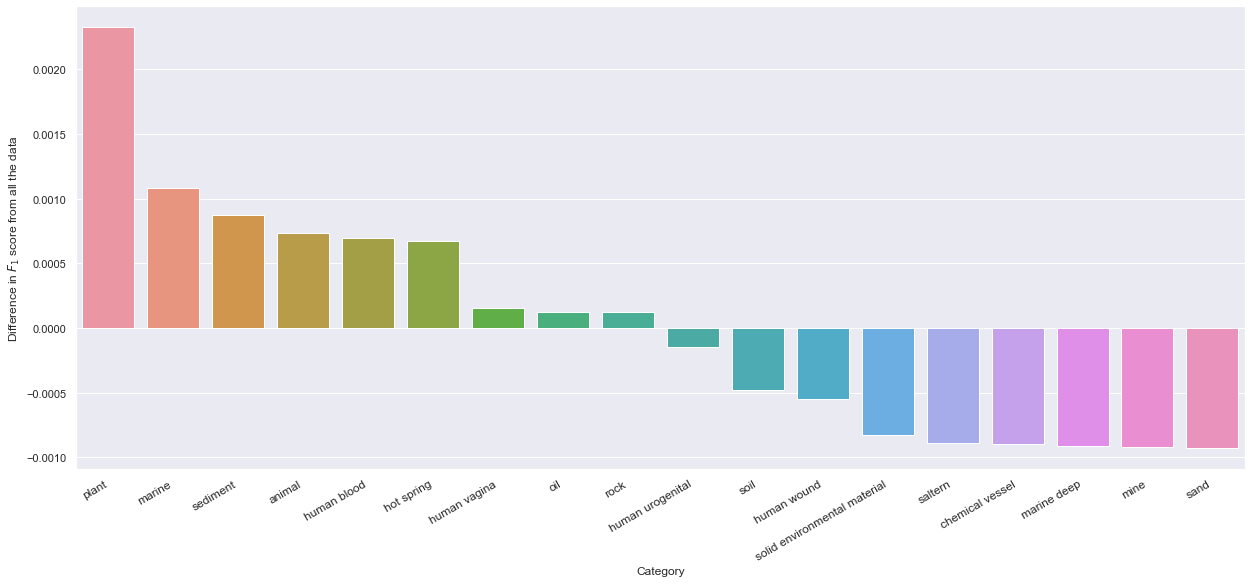

In [18]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
iccatgotop = iccatgo[iccatgo['f1 delta'].abs() > 0.0001].sort_values(by='f1 delta', ascending=False)
ax = sns.barplot(x='Category', y='f1 delta', data=iccatgotop)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=12)
ax.set_ylabel("Difference in $F_1$ score from all the data")
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('images/category_importance.png')
fig.savefig('images/category_importance.svg')

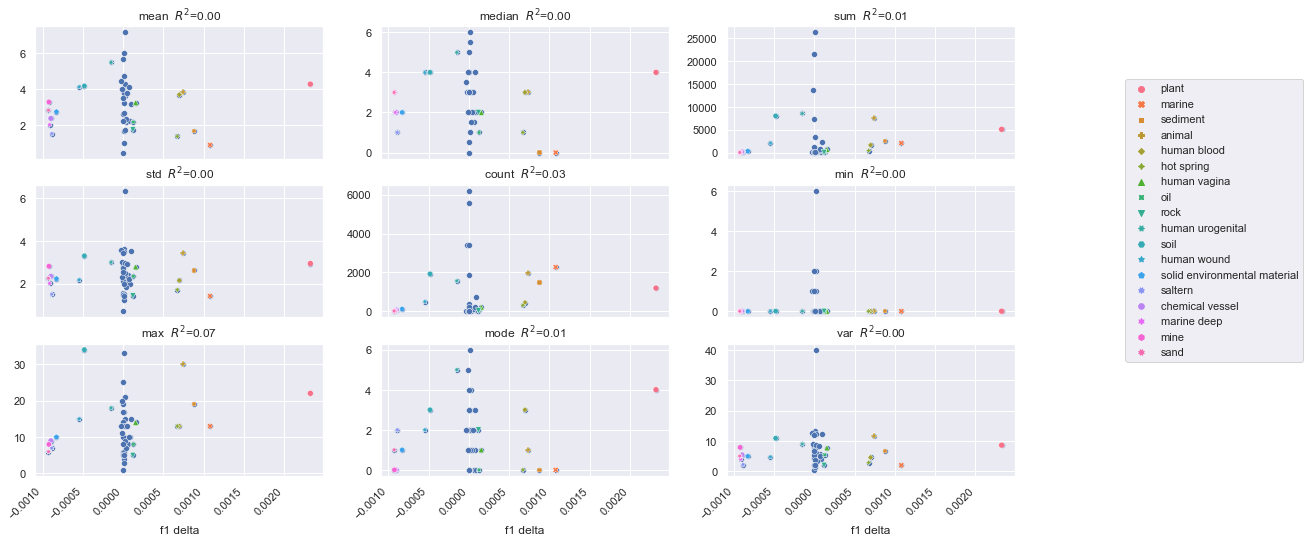

In [19]:
cols = [
        ['mean_phages', 'median_phages', 'sum_phages'],
        ['std_phages', 'count_phages', 'min_phages'], 
        ['max_phages', 'mode_phages', 'var_phages']
]

model = LinearRegression()

datalen = len(iccatgo['f1 delta'])
x = iccatgo['f1 delta'].fillna(0).values.reshape(datalen, 1)

#fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), sharex=True)
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True)

for i in 0,1,2:
    for j in 0,1,2:
        y = iccatgo[cols[i][j]].fillna(0).values.reshape(datalen, 1)
        m = model.fit(x, y)        
        bx = sns.scatterplot(x='f1 delta', y=cols[i][j], data=iccatgo, ax=ax[i][j])
        bx2 = sns.scatterplot(x='f1 delta', y=cols[i][j], data=iccatgotop, ax=ax[i][j], hue='Category', style='Category')
        bx2.get_legend().remove()
        bx.set_ylabel("")
        bx2.set_ylabel("")
        bx.set_title(f"{cols[i][j].replace('_phages', ' ')} $R^2$={m.score(x,y):.2f}")


l = plt.legend(bbox_to_anchor=(0,0,2,3), borderaxespad=0., ncol=1)
for i in 0, 1, 2:
    l = plt.setp(ax[2][i].get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.tight_layout() this gives an error : Tight layot not applied
fig.savefig('images/category_importance_why.png', bbox_inches = "tight")
fig.savefig('images/category_importance_why.svg')

In [20]:
iccatgotop

,Code,Category,f1 delta,mean_phages,median_phages,sum_phages,std_phages,count_phages,min_phages,max_phages,mode_phages,var_phages
35,40,plant,0.002324,4.270588,4.0,5082.0,2.938803,1190.0,0.0,22.0,4.0,8.636561
22,29,marine,0.001079,0.916189,0.0,2077.0,1.418276,2267.0,0.0,13.0,0.0,2.011507
39,44,sediment,0.000877,1.666441,0.0,2463.0,2.612992,1478.0,0.0,19.0,0.0,6.827729
1,1,animal,0.000737,3.820356,3.0,7507.0,3.423114,1965.0,0.0,30.0,1.0,11.717712
6,14,human blood,0.000697,3.690583,3.0,1646.0,2.145966,446.0,0.0,13.0,3.0,4.605170
5,13,hot spring,0.000672,1.391586,1.0,430.0,1.709046,309.0,0.0,13.0,0.0,2.920838
19,26,human vagina,0.000155,3.251163,2.0,699.0,2.783829,215.0,0.0,14.0,1.0,7.749707
32,38,oil,0.000128,2.177778,1.0,98.0,2.338306,45.0,0.0,8.0,0.0,5.467677
36,41,rock,0.000120,1.758621,2.0,51.0,1.430663,29.0,0.0,5.0,2.0,2.046798
18,25,human urogenital,-0.000150,5.470250,5.0,8550.0,3.003345,1563.0,0.0,18.0,5.0,9.020081


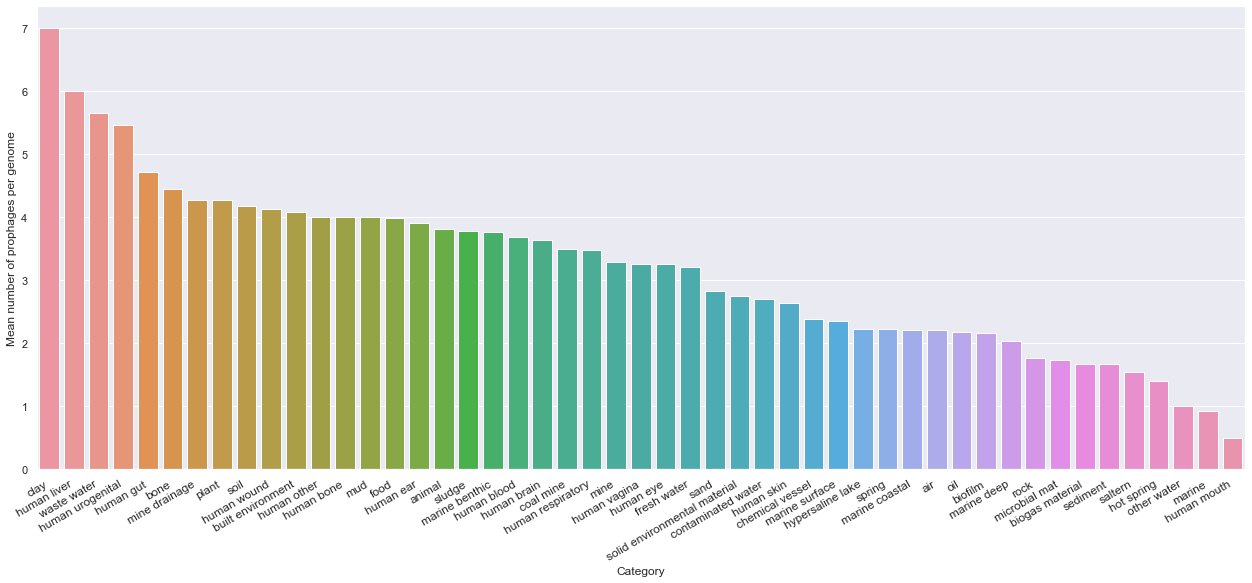

In [33]:
sns.set(rc={'figure.figsize':(17.55,8.27)})
iccatgotop = iccatgo[iccatgo['mean_phages'].abs() > 0.0001].sort_values(by='mean_phages', ascending=False)
ict = iccatgotop[iccatgotop['Category'] != 'fungus']
ax = sns.barplot(x='Category', y='mean_phages', data=ict)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize=12)
ax.set_ylabel("Mean number of prophages per genome")
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('images/category_mean_phages.png')
fig.savefig('images/category_mean_phages.svg')